In [1]:
import pandas as pd
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

In [38]:
raw_data = scipy.io.loadmat('../data/ECoG-1.mat')

In [159]:
raw_df = pd.DataFrame(raw_data['X']).T

In [160]:
%matplotlib inline

# Window size choice

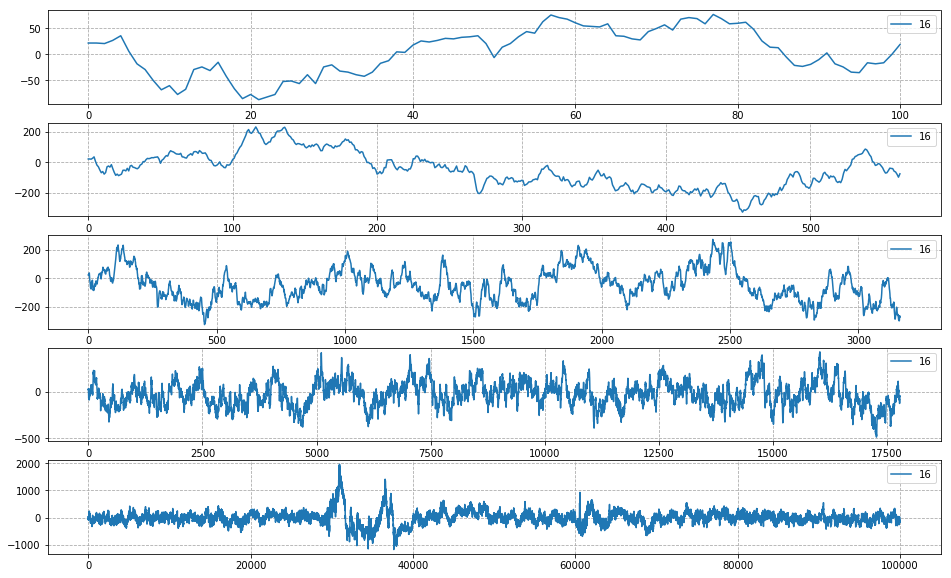

In [161]:
N = 5
fig, axes = plt.subplots(figsize=(16, 10), nrows=N, ncols=1)
axes = iter(axes)

for size in np.logspace(2, 5, N):
    ax = next(axes)
    raw_df[[16]].loc[0:size].plot(ax=ax)
    ax.grid(color='#AAAAAA', ls='--')

In [293]:
N_CHANNELS = 1
SAMPLE_SIZE = 300
OVERLAP = 10

# Split into series of `SAMPLE_SIZE` length with `OVERLAP` overlap

In [294]:
step = SAMPLE_SIZE - OVERLAP
series = [raw_df.loc[start : start + SAMPLE_SIZE - 1].reset_index(drop=True)
          for start in range(0, len(raw_df) - len(raw_df) % step, step)]

In [295]:
data = pd.concat(series, keys=range(0, len(series)))
data.index.names = ['Series', 't']

# Select `N_CHANNELS` channels

In [296]:
data = data.iloc[:, 0 : N_CHANNELS]

# Test DTW with various parameters

In [297]:
from dtwalign import dtw, dtw_low

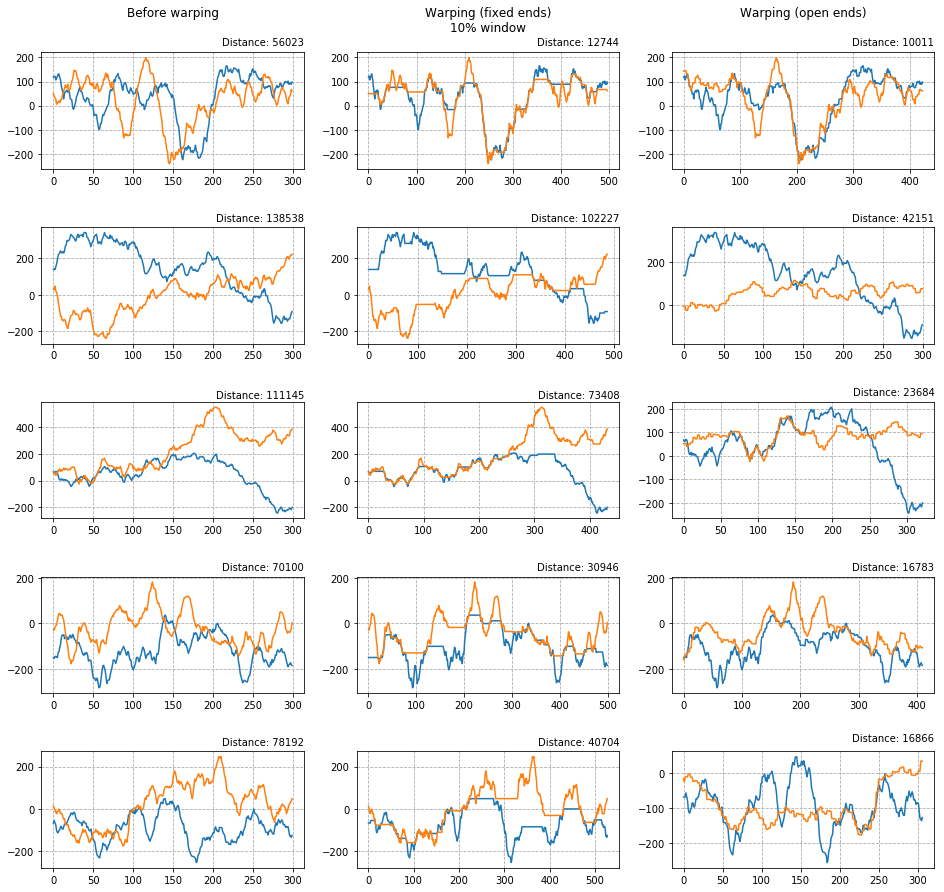

In [352]:
N = 5

fig, axes = plt.subplots(figsize = (16, 3*N) , nrows=N, ncols=3)

axes[0][0].set_title('Before warping\n\n')
axes[0][1].set_title('Warping (fixed ends)\n10% window\n')
axes[0][2].set_title('Warping (open ends)\n\n')

axes = iter(axes)

for n1, n2 in np.random.randint(0, len(series), (N, 2)):
    ax = next(axes)
    x = data.loc[n1].values
    y = data.loc[n2].values
    
    def _plot_aligned(ax, x, y, x_path, y_path, distance):
        ax.grid(color='#aaaaaa', ls='--')
        
        ax.plot(x[x_path])
        ax.plot(y[y_path])
        ax.text(ax.get_xlim()[1], ax.get_ylim()[1] + 30, f"Distance: {distance:.0f}", ha='right')
        
    res = dtw(x, y, window_type="sakoechiba", window_size=0)
    _plot_aligned(ax[0], x, y, x_path=res.path[:, 0], y_path=res.path[:, 1], distance=res.distance)

    res = dtw(x, y, window_type="sakoechiba", window_size=SAMPLE_SIZE*0.1)
    _plot_aligned(ax[1], x, y, x_path=res.path[:, 0], y_path=res.path[:, 1], distance=res.distance)
    
    X = cdist(x, y, metric="euclidean")
    res = dtw_low(X, open_end=True, open_begin=True,
              window = dtwalign.window.NoWindow(len(x), len(y)),
              pattern=dtwalign.step_pattern.AsymmetricP05())
    
    _plot_aligned(ax[2], x, y, x_path=res.path[:, 0], y_path=res.path[:, 1], distance=res.distance)
    
plt.subplots_adjust(hspace=0.5)

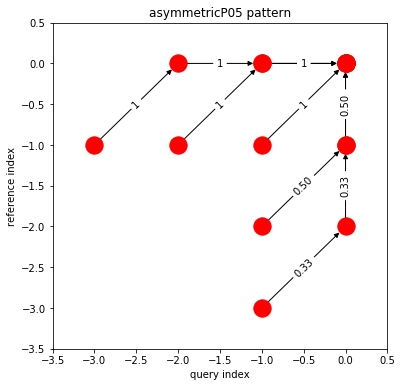

In [361]:
dtwalign.step_pattern.AsymmetricP05().plot()

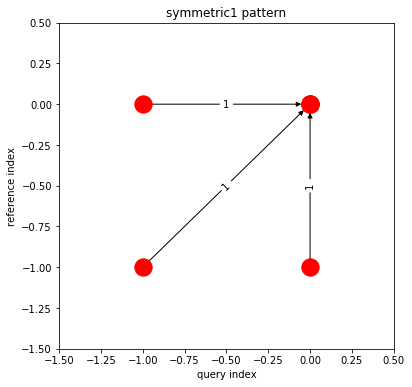

In [357]:
dtwalign.step_pattern.Symmetric1().plot()